<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S15-FinalAssignment-MaskDepth/S15Final_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My\ Drive/DenseDepth_DataSet

/content/gdrive/My Drive/DenseDepth_DataSet


In [0]:
!pwd

/content/gdrive/My Drive/DenseDepth_DataSet


In [0]:
import argparse
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torchvision import transforms


from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, random_split

In [0]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.468, 0.412, 0.252],std = [0.211, 0.211, 0.216])
])
dataset = DenseDataSet(transform=train_transforms, scale=1)
batch_size = 128
val_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])


train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)


Creating dataset with 100 examples


In [0]:
import matplotlib.pyplot as plt


def plot_img_and_mask(img, mask):
    classes = mask.shape[2] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i+1].set_title(f'Output mask (class {i+1})')
            ax[i+1].imshow(mask[:, :, i])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask)
    plt.xticks([]), plt.yticks([])
    plt.show()

images = next(iter(train_loader))
val_images = next(iter(val_loader))
fg_bg_image = images['fgbg_image']
mask_image = images['mask']

#plot_img_and_mask(fg_bg_image, mask_image)

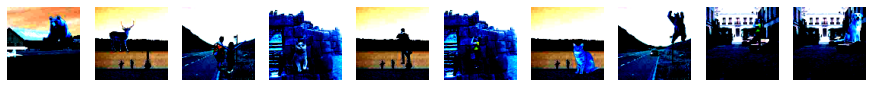

In [0]:
fg_bg_image.shape
fig = plt.figure(figsize=(200, 200))
num_imgs = fg_bg_image.shape[0]
for i in range(10):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    
    img = fg_bg_image[i]

    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    plt.imshow(npimg)
    plt.axis('off')

In [0]:
fg_bg_image.shape

torch.Size([64, 3, 224, 224])

In [0]:
mask_image.shape

torch.Size([64, 1, 224, 224])

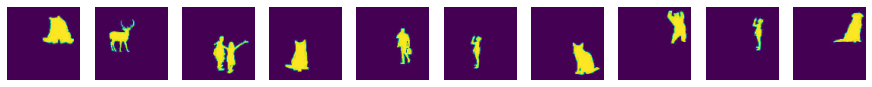

In [0]:

fig = plt.figure(figsize=(200, 200))
num_imgs = mask_image.shape[0]
for i in range(10):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    
    img = mask_image[i]
    mask = img[:, :, :]

    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    plt.imshow(npimg[:, :, 0])
    plt.axis('off')

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=6, n_classes=1, bilinear=True)
net.to(device=device)
from torchsummary import summary
summary(net, (6 , 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,520
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

In [0]:
import torch.nn as nn
img_scale=0.5
lr=0.01
epochs=20
save_cp=True

def adjust_learning_rate(opt, epoch):
    if epoch >= 5:
        lr = 0.01 * 0.1
        for param_group in opt.param_groups:
            param_group['lr'] = lr
net.load_state_dict(
    torch.load("checkpoints/CP_epoch10.pth", map_location=device)
)
writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

logging.info(f'''Starting training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {lr}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_cp}
    Device:          {device.type}
''')


optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=2)
criterion = nn.BCEWithLogitsLoss()
train_net(net, device, epochs=epochs, batch_size=batch_size, optimzer, schedular, criterion, writer, save_cp=True)